# TP cinématique et dynamique en analyse du mouvement 1
**Charles Pontonnier - Franck Multon**


## Exploration des données d'entrée



Ce petit code python a pour objectif d'investiguer la nature des données d'entrée en analyse du mouvement, en particulier les trajectoires de marqueurs en capture du mouvement et les plateformes de force.
![alt text](escrime_overview.png "Title")

L'expérimentation consiste en une série d'essais de touche sur une cible virtuelle représentant un plastron. Lors de ces expérimentations, nous avons joué sur la nature des cibles apparaissant sur le plastron, elles pouvaient parfois être fixes, parfois mobiles, parfois incertaines (susceptibles d'être mobiles). Nous investiguions dans ce cadre la réponse des épéistes face à l'incertitude. Les données expérimentales utilisées dans ce tutoriel sont issues de ces expérimentations. Les études découlant de cette expérimentation sont disponibles dans les publications suivantes:

Sorel, A., Plantard, P., Bideau, N., & Pontonnier, C. (2019). Studying fencing lunge accuracy and response time in uncertain conditions with an innovative simulator. Plos One, 14(7), e0218959. 

Plantard, P., Sorel, A., Bideau, N., & Pontonnier, C. (2017). Motion adaptation in fencing lunges: a pilot study. Computer methods in biomechanics and biomedical engineering, 20(sup1), S161-S162.

Pontonnier, C., Livet, C., Muller, A., Sorel, A., Dumont, G., & Bideau, N. (2019). Ground reaction forces and moments prediction of challenging motions: fencing lunges. Computer methods in biomechanics and biomedical engineering, 22(sup1), S523-S525.

![alt text](expe_setup.png "Title")

Nous allons particulièrement investiguer deux questions principales:
a.  quelle adaptation réalise l'escrimeur au cours de sa fente, lorsque la cible change ?
b. quel couple l'escrimeur développe-t-il au niveau du genou d'appui lors de la fente ?

## Setup du Notebook

In [1]:
import ezc3d 
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

## Ouverture du fichier et récupération des données 

In [2]:
#Ouverture du fichier
c = ezc3d.c3d('../DATA/Trial010.c3d')
print('Nombre de marqueurs présents:',c['parameters']['POINT']['USED']['value'][0]); # nombre de marqueurs 

## Affichage du contenu des différents dictionnaires
#print(c['header'].keys())
#print(c['data'].keys())
#print(c['parameters']['FORCE_PLATFORM'].keys())

point_data = c['data']['points'] #récupération trajectoires marqueurs
point_labels=c['parameters']['POINT']['LABELS']# récupération labels marqueurs
point_rate=c['parameters']['POINT']['RATE'] # récupération fréquence mocap
analog_data = c['data']['analogs'] # récupération données analogiques
analog_labels=c['parameters']['ANALOG']['LABELS'] # récupération labels analogiques
analog_rate=c['parameters']['ANALOG']['RATE'] # récupération fréquence analogique

print('fréquence échantillonnage capture de mouvement:', point_rate['value'][0],'Hz')
print('fréquence échantillonnage données analogiques:', analog_rate['value'][0],'Hz')
# nombre d'échantillons mocap et analog
nf_mocap=len(point_data[0][0][:])
nf_analog=len(analog_data[0][0][:])
#reconstruction vecteur temps capture et signaux analogiques
t_point=np.linspace(0., nf_mocap/point_rate['value'][0], num=nf_mocap)
t_analog=np.linspace(0., nf_analog/analog_rate['value'][0], num=nf_analog)

print(point_labels)


Nombre de marqueurs présents: 45
fréquence échantillonnage capture de mouvement: 250.0 Hz
fréquence échantillonnage données analogiques: 1000.0 Hz
{'type': -1, 'description': 'Trajectory labels', 'is_locked': False, 'value': ['LCAR', 'LFHD', 'LBHD', 'RFHD', 'RBHD', 'C7', 'T10', 'CLAV', 'STRN', 'LSHO', 'LUPA', 'LRAD', 'LHUM', 'LWRB', 'LWRA', 'RSHO', 'RBAC', 'RUPA', 'RRAD', 'RHUM', 'RWRB', 'RWRA', 'RCAR', 'LFWT', 'LBWT', 'RFWT', 'RBWT', 'LTHI', 'LKNE', 'LKNI', 'LANE', 'LANI', 'LHEE', 'LTAR', 'LTARI', 'LTOE', 'RTHI', 'RKNE', 'RKNI', 'RANE', 'RANI', 'RHEE', 'RTAR', 'RTARI', 'RTOE']}


## Tracé de la position de la main au cours de l'attaque

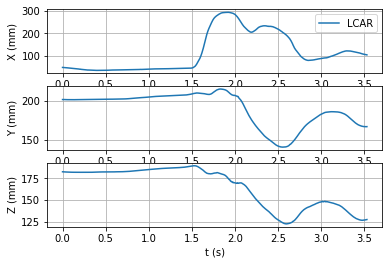

In [4]:
plt.subplot(3,1,1)
plt.grid()
plt.plot(t_point,point_data[0][0][:])
plt.xlabel('t (s)')
plt.ylabel('X (mm)')
plt.legend(point_labels['value'][0:3])

plt.subplot(3,1,2)
plt.grid()
plt.plot(t_point,point_data[0][1][:])
plt.xlabel('t (s)')
plt.ylabel('Y (mm)')

plt.subplot(3,1,3)
plt.grid()
plt.plot(t_point,point_data[0][2][:])
plt.xlabel('t (s)')
plt.ylabel('Z (mm)')

plt.show()

<font color='green'>**Question 1: tracer l'évolution des coordonnées au cours du temps du marqueur LTOE (gros orteil gauche)**</font>

In [5]:
# S'inspirer des lignes ci-dessus pour le faire

## Filtrage  et dérivation de la composante en X de la trajectoire du marqueur main

Pour pouvoir obtenir la vitesse et l'accéléaration des marqueurs, il est nécessaire de dériver leur position au cours du temps. Il est notoire que la différentiation numérique tend à amplifier l'erreur de mesure, c'est pourquoi il est courant de filtrer auparavant les données de position pour limiter l'impact de la différentation. Dans la suite, on met en place un filtre passe bas pour dériver la position du marqueur LCAR.

<font color='green'>**Question 2: Tester différentes valeurs de fréquence de coupure pour le filtre passe bas et déterminer une fréquence pertinente pour la différentiation.**</font>

In [6]:
f_coupure=2 #Modifier ici la fréquence de coupure

# filtre passe-bas, no phase shift

b, a = signal.butter(4, f_coupure, btype='low', analog=False, output='ba', fs=point_rate['value'][0])
y = signal.filtfilt(b, a, point_data[0][0][:], padlen=150)
# dérivée du signal filtré
deriv1=np.diff(y)*point_rate['value'][0]
# dérivée du signal brut
deriv2=np.diff(point_data[0][0][:])*point_rate['value'][0]

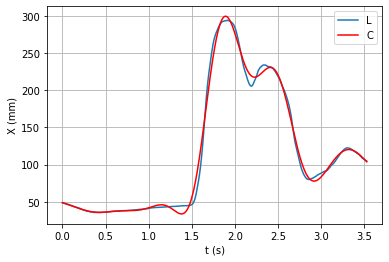

In [7]:
# Tracé des signaux bruts et filtrés
plt.grid()
plt.plot(t_point,point_data[0][0][:])
plt.plot(t_point,y,'r')
plt.xlabel('t (s)')
plt.ylabel('X (mm)')
l=point_labels['value'][0]
plt.legend(point_labels['value'][0])#TOFIX

plt.show()

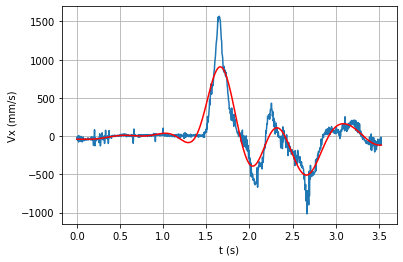

In [8]:
# TODO tracé des signaux dérivés (brut et filtré)
plt.grid()
plt.plot(t_point[:-1],deriv2)
plt.plot(t_point[:-1],deriv1,'r')

plt.xlabel('t (s)')
plt.ylabel('Vx (mm/s)')

plt.show()

## Données de plateforme de force 

On va à présent investiguer les données de plateforme de force.
Pour pouvoir récupérer ces informations, il est nécessaire de se pencher sur le contenu des dictionnaires "Analog" et "Analog_labels".

<font color='green'>**Question 3: Explorer les dictionnaires Analog et Analog_labels pour tracer les efforts Fx Fy Fz de la plateforme n°1. Utiliser pour cela la commande .keys() (voir cellule d'ouverture du C3D).**</font>

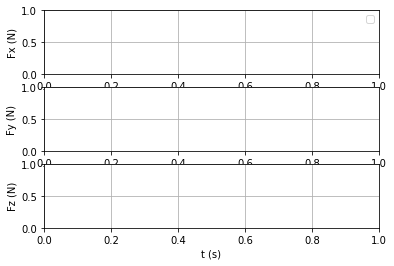

In [9]:
plt.subplot(3,1,1)
plt.grid()

plt.xlabel('t (s)')
plt.ylabel('Fx (N)')


plt.subplot(3,1,2)
plt.grid()

plt.xlabel('t (s)')
plt.ylabel('Fy (N)')

plt.subplot(3,1,3)
plt.grid()

plt.xlabel('t (s)')
plt.ylabel('Fz (N)')

plt.show()
